# Modelo sarima

### Carga del dataset

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('../data/DailyDelhiClimateTrain.csv')
print(df.head())
print(df.info())

         date   meantemp   humidity  wind_speed  meanpressure
0  2013-01-01  10.000000  84.500000    0.000000   1015.666667
1  2013-01-02   7.400000  92.000000    2.980000   1017.800000
2  2013-01-03   7.166667  87.000000    4.633333   1018.666667
3  2013-01-04   8.666667  71.333333    1.233333   1017.166667
4  2013-01-05   6.000000  86.833333    3.700000   1016.500000
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1462 entries, 0 to 1461
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   date          1462 non-null   object 
 1   meantemp      1462 non-null   float64
 2   humidity      1462 non-null   float64
 3   wind_speed    1462 non-null   float64
 4   meanpressure  1462 non-null   float64
dtypes: float64(4), object(1)
memory usage: 57.2+ KB
None


### Parseo de fecha e índice temporal

In [13]:
# Convertir a datetime y ordenar por fecha
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date').set_index('date')

### Seleccionar una variable univariante (TS)

In [14]:
#Serie temporal con frecuencia diaria
y = df['meantemp'].asfreq('D')  # frecuencia diaria (D)

# Comprobar valores faltantes
print("Valores NaN:", y.isna().sum())

# Rellenar huecos por interpolación si existen
y = y.interpolate()



Valores NaN: 0


### Visualización

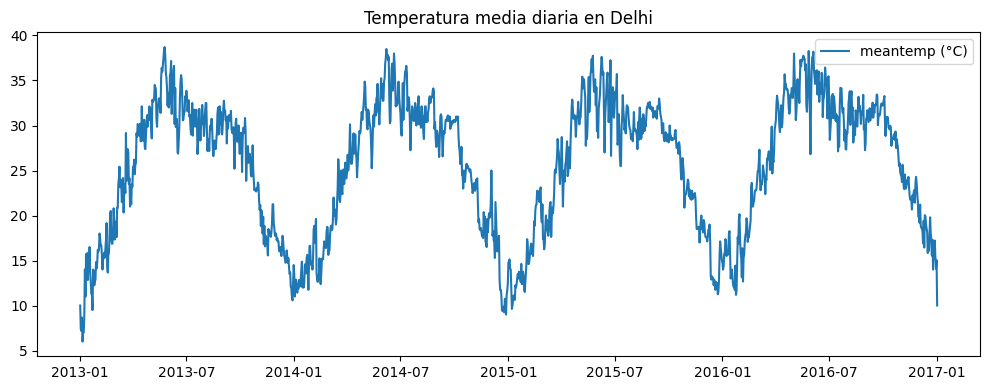

In [15]:
plt.figure(figsize=(10,4))
plt.plot(y, label='meantemp (°C)')
plt.title('Temperatura media diaria en Delhi')
plt.legend()
plt.tight_layout()
plt.show()

### Análisis de estacionalidad y tendencia

In [16]:
from statsmodels.tsa.seasonal import seasonal_decompose

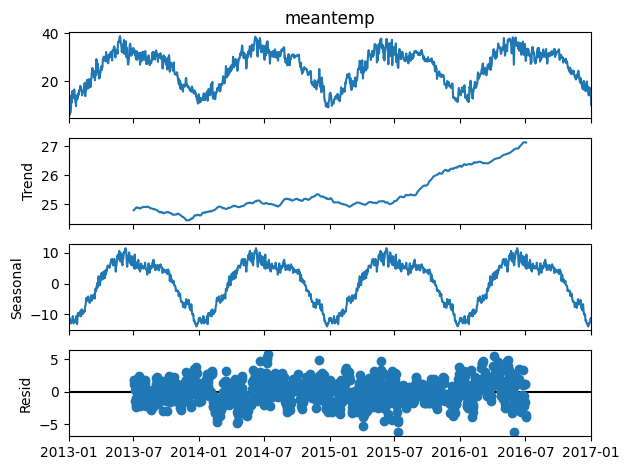

In [8]:
# Descomposición estacional para observar patrones
decomposition = seasonal_decompose(y, model='additive', period=365)
decomposition.plot()
plt.show()


### Test de estacionariedad (ADF)

In [17]:
from statsmodels.tsa.stattools import adfuller

adf_result = adfuller(y)
print(f'Estadístico ADF: {adf_result[0]}')
print(f'Valor p: {adf_result[1]}')

if adf_result[1] > 1:
    print("\nLa serie NO es estacionaria. Aplicando diferenciación...")
    y_diff = y.diff().dropna()
    y = y_diff
else:
    print("\nLa serie es estacionaria.")

Estadístico ADF: -2.0210690559206714
Valor p: 0.2774121372301609

La serie es estacionaria.


# Definir y entrenar SARIMA

In [18]:
# División temporal 80% - 20%
train_size = int(len(y) * 0.8)
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

print("Tamaño entrenamiento:", len(y_train))
print("Tamaño test:", len(y_test))

Tamaño entrenamiento: 1169
Tamaño test: 293


In [20]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# SARIMA(p, d, q)(P, D, Q, s)
# p,d,q → No estacional | P,D,Q → Estacional | s → periodicidad (365 días para datos diarios)
model = SARIMAX(
    y_train,
    order=(2, 1, 2),
    seasonal_order=(1, 1, 1, 12),
    enforce_stationarity=False,
    enforce_invertibility=False
)

model_fit = model.fit(disp=False)
print(model_fit.summary())


                                      SARIMAX Results                                       
Dep. Variable:                             meantemp   No. Observations:                 1169
Model:             SARIMAX(2, 1, 2)x(1, 1, [1], 12)   Log Likelihood               -2175.165
Date:                              Thu, 16 Oct 2025   AIC                           4364.330
Time:                                      19:59:31   BIC                           4399.608
Sample:                                  01-01-2013   HQIC                          4377.652
                                       - 03-14-2016                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3256      0.075     -4.345      0.000      -0.472      -0.179
ar.L2          0.53

## Diagnóstico del modelo

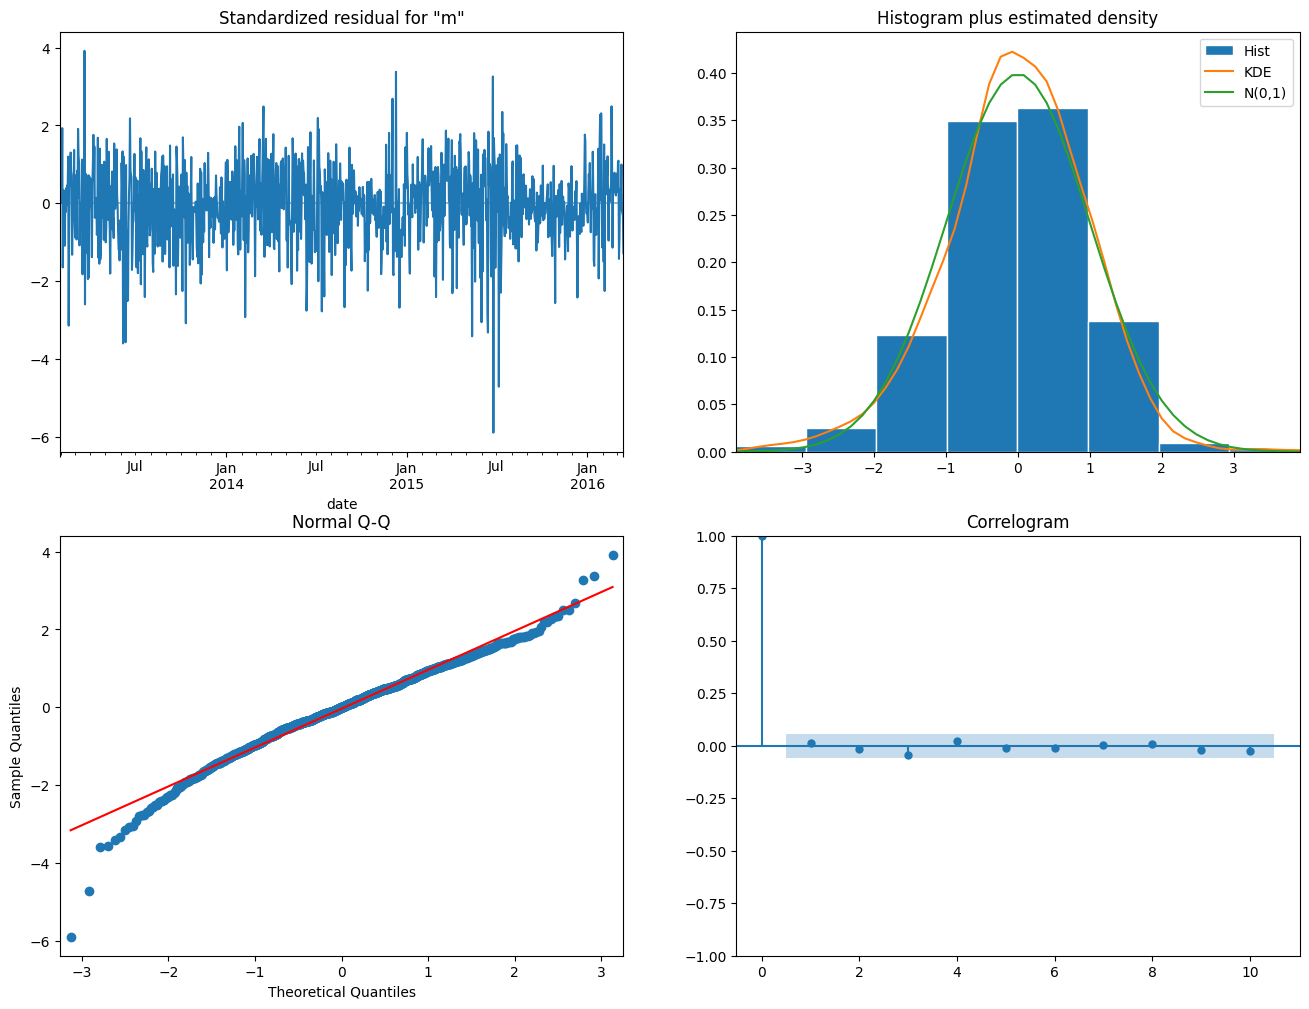

In [28]:
model_fit.plot_diagnostics(figsize=(16, 12))
plt.show()

## Predicción sobre datos de test

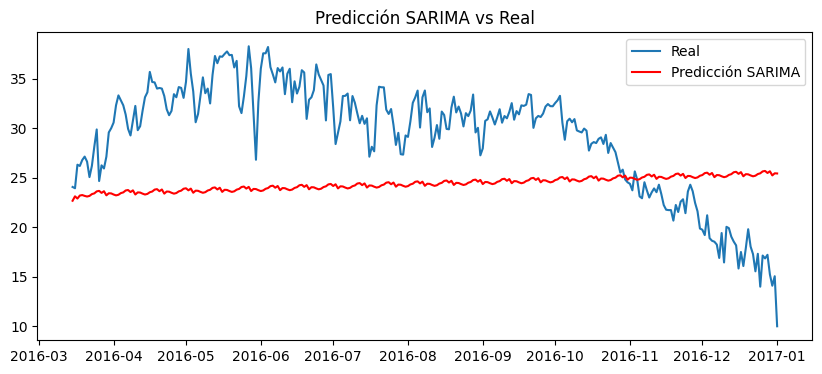

In [41]:
# Predicción sobre el conjunto de test
forecast = model_fit.forecast(steps=len(y_test))

plt.figure(figsize=(10,4))
plt.plot(y_test.index, y_test, label='Real')
plt.plot(y_test.index, forecast, label='Predicción SARIMA', color='red')
plt.title('Predicción SARIMA vs Real')
plt.legend()
plt.show()

## Evaluación del modelo

In [38]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

mae = mean_absolute_error(y_test, forecast)
rmse = mean_squared_error(y_test, forecast)

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")


MAE: 7.03
RMSE: 60.78


## Pronóstico futuro

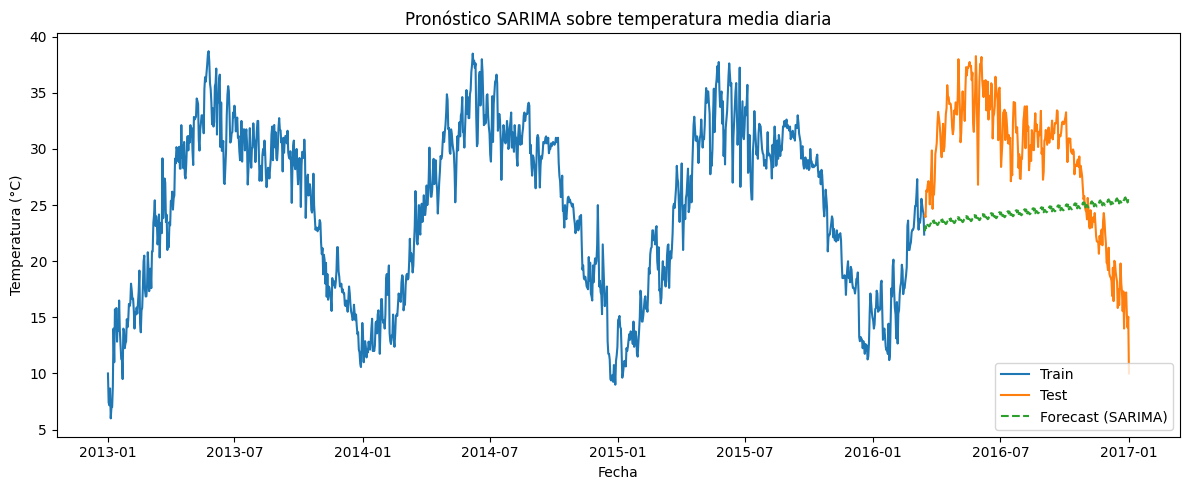

In [42]:


plt.figure(figsize=(12,5))
plt.plot(y_train.index, y_train, label="Train")
plt.plot(y_test.index, y_test, label="Test")
plt.plot(y_test.index, forecast, label="Forecast (SARIMA)", linestyle="--")
plt.title('Pronóstico SARIMA sobre temperatura media diaria')
plt.xlabel('Fecha')
plt.ylabel('Temperatura (°C)')
plt.legend()
plt.tight_layout()
plt.show()
